# Integrating social capital metrics into director career data

Welcome to the next phase in our exploration of how social networks impact movie directors' careers. 

**What are we aiming to do?**

Previously, we calculated the annual brokerage scores for every creative worker in the film industry from 2003 to 2023 (see notebook `Phase_2_Constructing_Filmmaker_Network.ipynb`). These scores include effective size, constraint, and local clustering.
We also created a time series dataset tracing each year in a director's career from their debut to 2023 (see notebook `Phase_4_Building_Time_Series_Data.ipynb`). 

Now, we turn our attention to identifying the collaborators of movie directors to find and integrate their brokerage social capital scores into our time series dataset, so that we can have information on the collaborators' social capital at the time of their collaboration with the director. 

In [1]:
# Importing necessary libraries for data manipulation and handling
import pandas as pd  # data manipulation
import numpy as np # numerical operations
import os  # interacting with the operating system, such as changing directories
import pickle  # loading serialized data
import dask.dataframe as dd
import random
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization

# Set the working directory to where the project files are located
os.chdir('/Users/mac/Library/CloudStorage/OneDrive-McGillUniversity/Work/Projects/Gender and brokerage/WomenLeaders_SocialNetworks')

# Identifying collaborators of movie directors

Our first task is to **link each director to their collaborators based on movies.**

For this, we'll use two datasets: 
- `directors_full_filmography` dataset: Previously created in `Phase_1_Tracking_Movie_Directors_Career.ipynb`, this dataset lists all movies directed by the directors in our sample.
- IMDb's `title.principals.tsv.gz` dataset: Sourced from IMDb's extensive database, this dataset provides details on all personnel involved in movie productions.

Here is how we do it:
- We begin by filtering the IMDb's principals data to spotlight the people in key creative roles—director, producer, writer, editor, cinematographer, production_designer, composer. 
- We then merge the refined IMDb data with our directors' filmography based on movie IDs. This creates the `directors_network` dataset, where each row is a director-collaborator-year combination, with the following columns:
    - Movie ID (`tconst`): Unique identifier for each film.
    - Movie Release Year (`startYear`): Indicates when the movie was released.
    - Director's ID (`nconst_director`): Unique identifier for the director.
    - Director's Debut Year (`firstYear`): Marks the year each director made their debut.
    - Collaborator's ID (`nconst`): Unique identifier for each collaborator.

Our text task is to **identify recent collaborators for each year.** 

For this, we'll use two datasets: 
- `directors_network`: Our newly created dataset of director-collaborator connections by year. 
- `directors_years`: Previously created in `Phase_4_Building_Time_Series_Data.ipynb`, this dataset traces each year of a director's career from their debut to the present year (2023).

Here are the steps:
- We define a specific time frame for each year in a director’s career, considering the current year and the two preceding years. 
- For each director and each year, we apply a function to assemble a list of collaborators who worked with the director in the specified time frame. This creates the `collaborators_by_year` dataset, which has the following columns: 
    - Director's ID (`nconst_director`): Unique identifier for the director.
    - Current year (`year`): The focal year under analysis.
    - Collaborators List (`nconst`): Lists all creative professionals the director has collaborated with over a three-year period, including the current year and the two years before that.

In [4]:
# Load data on filmography of directors
directors_full_filmography = pd.read_csv('directors_full_filmography.csv')

# Display the first few rows of each dataset to understand their structure
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.0,"Comedy,Mystery",nm1131265,2004.0,7.8,34.0
1,tt0108549,2004.0,"Comedy,Mystery",nm1130611,2004.0,7.8,34.0
2,tt0117461,2003.0,"Comedy,Romance",nm0290651,2003.0,6.3,24.0
3,tt0117743,2008.0,"Drama,Romance",nm0404033,2003.0,6.7,64.0
4,tt0118141,2005.0,Drama,nm0000417,2005.0,5.3,950.0


So, in the `directors_full_filmography` dataset, each row is a movie made by a director in the sample (thus a director can have several rows if they made several movies). The columns are the movie ID (`tconst`), the year the movie was released (`startYear`), the director's ID (`nconst`), the director's debut year (`firstYear`), along with other characteristics of the movie: its genres (`genres`), average rating in IMDb (`averageRating`), number of votes in IMDb (`numVotes`).

Now, we connect directors to all individuals involved in creative roles in their films.

In [ ]:
# Accessing the IMDb title principals dataset, which lists the key personnel involved in movie productions
url_principals = 'https://datasets.imdbws.com/title.principals.tsv.gz'

# Loading the dataset choosing only relevant columns: 'tconst' for title ID, 'nconst' for name ID, and 'category' for the role of the individual
df_principals = pd.read_csv(url_principals, sep='\t', compression='gzip', encoding='utf-8', low_memory=False, usecols=['tconst', 'nconst', 'category'])

# Narrowing down the principals dataset to include only individuals in creative roles. 
creative_roles = ['director', 'producer', 'writer', 'editor', 'cinematographer', 'production_designer', 'composer']
df_principals = df_principals[df_principals['category'].isin(creative_roles)]

# Preparing the directors' network dataset by first renaming the 'nconst' column for clarity and selecting relevant columns. 
# This dataset includes each movie's title ID, the start year of the movie, the director's unique ID, and the director's debut year.
directors_network = directors_full_filmography.rename(columns={'nconst': 'nconst_director'})[['tconst', 'startYear', 'nconst_director', 'firstYear']]

# Merging the directors' network dataset with the principals dataset on the 'tconst' column to link directors with other creative personnel involved in the same movies. 
directors_network = pd.merge(directors_network, df_principals[['tconst', 'nconst']], on='tconst', how='inner')

# Filtering out entries containing the directors ID in the collaborator column
directors_network = directors_network[directors_network['nconst_director'] != directors_network['nconst']]

In [3]:
# Display the first few rows of each dataset 
directors_network.head()

,tconst,startYear,nconst_director,firstYear,nconst
0,tt0108549,2004,nm1131265,2004.0,nm0168948
1,tt0108549,2004,nm1131265,2004.0,nm1130611
2,tt0108549,2004,nm1131265,2004.0,nm0111876
3,tt0108549,2004,nm1131265,2004.0,nm2382648
4,tt0108549,2004,nm1131265,2004.0,nm0828024


Now for each year in a director's career, we find the people they worked with for the last 3 years. For this, we use the `directors_years` data created in a previous notebook, which lists each year (`year`) in a director's (`nconst_director`) career from their debut to present year, 2023.

In [4]:
# load yearly data of directors
directors_years = pd.read_csv('directors_years.csv')

# Display the first few rows of the dataset to understand their structure
directors_years.head()

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5


In [5]:
# Converting director and collaborator IDs to categorical data types for efficient memory use
directors_network[['nconst_director', 'nconst']] = directors_network[['nconst_director', 'nconst']].astype('category')
directors_years['nconst_director'] = directors_years['nconst_director'].astype('category')

# Merging the yearly data of directors with their network data based on director IDs
merged_data = pd.merge(directors_years[['nconst_director', 'year']], 
                       directors_network.drop_duplicates(subset=['tconst', 'nconst_director', 'nconst']), 
                       on='nconst_director', how='left')

# Calculating the time frame (current year minus 2 to current year) to identify collaborators 
merged_data['year_min'] = merged_data['year'] - 2
merged_data['year_max'] = merged_data['year']

# Filtering to include only collaborations within the specified time frame
merged_data = merged_data[(merged_data['startYear'] >= merged_data['year_min']) & (merged_data['startYear'] <= merged_data['year_max'])]

In [13]:
# Display the first few rows of the data linking the directors to recent collaborators
merged_data.head(25)

,nconst_director,year,tconst,startYear,firstYear,nconst,year_min,year_max
0,nm1131265,2004,tt0108549,2004.0,2004.0,nm0168948,2002,2004
1,nm1131265,2004,tt0108549,2004.0,2004.0,nm1130611,2002,2004
2,nm1131265,2004,tt0108549,2004.0,2004.0,nm0111876,2002,2004
3,nm1131265,2004,tt0108549,2004.0,2004.0,nm2382648,2002,2004
4,nm1131265,2004,tt0108549,2004.0,2004.0,nm0828024,2002,2004
7,nm1131265,2005,tt0108549,2004.0,2004.0,nm0168948,2003,2005
8,nm1131265,2005,tt0108549,2004.0,2004.0,nm1130611,2003,2005
9,nm1131265,2005,tt0108549,2004.0,2004.0,nm0111876,2003,2005
10,nm1131265,2005,tt0108549,2004.0,2004.0,nm2382648,2003,2005
11,nm1131265,2005,tt0108549,2004.0,2004.0,nm0828024,2003,2005


In our current dataset, `merged_data`, each row details a single collaboration between a director and a collaborator. While this format provides a granular view of each connection, it leads to a substantial increase in the dataset's size and the computational resources needed for processing. Specifically, each director-year combination can appear in multiple rows, each representing a different collaborator. This repetition complicates our data handling and can slow down our analyses considerably.

Thus, let's transform `merged_data` into a more compact dataset by consolidating the information so that each director-year pair is represented by a single row, rather than multiple rows. In this new dataframe `collaborators_by_year`, each row corresponds to one director in one specific year, and includes a list of all collaborators associated with that director for the year. This captures the same information in a more efficient structure, simplifying querying and analyzing the dataset. 

In [14]:
# Grouping the data by director and year, then compiling a list of unique collaborators for each director-year pair.
collaborators_by_year = merged_data.groupby(['nconst_director', 'year'])['nconst'].apply(lambda x: list(set(x.dropna()))).reset_index()

# Display the first few rows of the result
collaborators_by_year.head()

,nconst_director,year,nconst
0,nm0000083,2007,"[nm1677271, nm0653114, nm0690875, nm0917916, n..."
1,nm0000083,2008,"[nm1677271, nm0653114, nm0690875, nm0917916, n..."
2,nm0000083,2009,"[nm1677271, nm0653114, nm0690875, nm0917916, n..."
3,nm0000136,2009,"[nm0463406, nm0003011]"
4,nm0000136,2010,"[nm0463406, nm0003011]"


With `collaborators_by_year`, we can more easily apply complex functions to each director-year pair, such as extracting or computing brokerage scores for the collaborators.

# Mapping brokerage scores to collaborators 

Previously, in `Phase_2_Constructing_Filmmaker_Network.ipynb`, we calculated the annual brokerage scores for every creative worker in the film industry from 2003 to 2023. These metrics, which include constraint, effective size, and local clustering, were stored in a pickle file named `brokerage_scores_by_year.pkl`. Now, we'll get the brokerage scores of the directors' collaborators from this file.

**Calculating collaborators' degree centrality**

I had originally planned to calculate the degree centrality of creative workers alongside their brokerage scores during the network construction phase (`Phase_2_Constructing_Filmmaker_Network.ipynb`). However, I forgot to do this. But that's ok, we can do it now. 

Degree centrality, which measures the number of direct connections a person has within a network, offers a straightforward yet powerful source of social capital. It is a key indicator of a person's network breadth and connectivity within the industry. Thankfully, degree centrality is a lot simpler to calculate than brokerage. We don't need to construct large-scale network graphs like we did before—which takes a lot of time with networks like ours that involves hundreds of thousands of people and billions of potential connections among them. 

We can calculate degree centrality directly from these two datasets:
- `merged_data`: Created above, this dataset links directors with their collaborators at the time of their collaboration.
- `movies_collaborations_2000_2023`: Created in `Phase_2_Constructing_Filmmaker_Network.ipynb`, this dataset lists everyone who worked on movies from 2000 to 2023. 

Here are the steps to calculate collaborators' degree centrality:
- From `merged_data`, we extract unique combinations of collaborators and the years of their collaborations with the director.
- Then we create a function, `calculate_degree_centrality`, that does the following:
   - For each collaborator, identify the films they worked on within a three-year period leading up to the current analysis year. 
   - Count the number of creative workers involved in these films excluding the focal collaborator. This gives us a measure of each collaborator's network centrality at the time of their collaboration with the director. 
   - Convert the results into a dictionary called `collaborator_degree_centrality` for efficient access in subsequent analyses.

**Mapping brokerage and degree centrality scores to collaborators**

Next, we define a function to integrate these network metrics into our primary dataset, `collaborators_by_year`. This function, `map_all_brokerage_scores`, is designed to retrieve each collaborator's brokerage and degree centrality scores from the `brokerage_scores_by_year` and `collaborator_degree_centrality` dictionaries, based on their ID (`nconst`) and the specific year (`year`). Then we apply this fucntion to each row of the `collaborators_by_year` DataFrame, which will then have the social capital metrics of the collaborators at the time of their collaboration with the director.

First, let's load the `brokerage_scores_by_year.pkl` file, which houses the calculated brokerage scores for every creative worker in the film industry from 2003 to 2023, to understand its structure and think about how we can extract collaborators' brokerage scores from it!

In [3]:
# Loading brokerage social capital metrics from a serialized file.
# This data includes brokerage scores for every filmmaker in the network by year, providing insight into their network influence.
brokerage_scores_by_year = pd.read_pickle('brokerage_scores_by_year.pkl')

In [4]:
# Print the dictionary keys, which are the years for which data is available.
# This is to ensure the data covers the expected timeframe.
print("Years in the dataset:", list(brokerage_scores_by_year.keys()))

Years in the dataset: [2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]


In [13]:
# Check the structure of a nested dictionary by picking a sample year
sample_year = next(iter(brokerage_scores_by_year))  # Get the first year in the dictionary
# Print the keys of the nested dictionary for the first year in the data, which are the types of brokerage scores available.
print(f"Brokerage score types available in {sample_year}:", list(brokerage_scores_by_year[sample_year].keys()))

Brokerage score types available in 2003: ['constraint', 'effective_size', 'local_clustering']


In [17]:
# Pick one type of score to sample, for example 'constraint'
score_type = 'constraint'
# Sample 10 random IDs within the 'constraint' scores
sample_ids = random.sample(list(brokerage_scores_by_year[sample_year][score_type].keys()), 10)
# Print the constraint scores for the randomly selected people
print(f"Random sample of {score_type} scores for {sample_year}:")
for nconst in sample_ids:
        print(f"ID {nconst}: {brokerage_scores_by_year[sample_year][score_type][nconst]}")

Random sample of constraint scores for 2003:
ID nm1131241: 0.6480000000000001
ID nm0304665: 0.5920000000000001
ID nm0359881: 0.557045422116528
ID nm9676743: 0.925925925925926
ID nm0406824: 0.3872507129687975
ID nm0401195: 0.39246337500982253
ID nm3125679: 0.5730879157218443
ID nm1231635: 0.6576599482248521
ID nm0494583: 0.6158045097439037
ID nm0542029: 0.2862404599916958


So, our data is organized in a multi-layered dictionary format, where:
- The top layer corresponds to each year.
- The second layer categorizes data into the types of brokerage scores.
- The deepest layer maps individual IDs (`nconst`) to their respective scores.
This structure allows us to efficiently retrieve any individual’s brokerage score for a specific year and score type.

Think of the data as a set of filing cabinets, where each cabinet is dedicated to a specific year. Inside each cabinet, there are several folders, each labeled according to the type of brokerage scores it contains—such as "constraint," "effective size," or "local clustering." Each folder is filled with individual files; each file pertains to a specific person (`nconst`). The information in the file is the person's score for that specific type of brokerage during that year. If we want to find out a person’s score for a certain type of brokerage metric in a given year, we would first choose the correct year's cabinet, select the folder for the score type we are interested in, and then find the file labeled with the person’s ID.

Now we move on to calculating collaborators' degree centrality at the time of their collaboration with the director. First, we load the `movies_collaborations_2000_2023` data, which links movies to the creative professionals involved in their production.

In [12]:
# load the movies_collaborations_2000_2023 dataset.
# this includes all individuals collaborated on each film released between 2000 and 2023.
movies_collaborations_2000_2023 = pd.read_csv('movies_collaborations_2000_2023.csv')

# Display the first few rows of the dataset to understand its structure and contents.
movies_collaborations_2000_2023.head()

,tconst,nconst,category,startYear
0,tt0011801,nm0483944,writer,2019.0
1,tt0011801,nm1773808,cinematographer,2019.0
2,tt0013274,nm0412842,director,2021.0
3,tt0013274,nm0895048,director,2021.0
4,tt0013274,nm13054604,producer,2021.0


So, the `movies_collaborations_2000_2023` is set up so that each row is a movie-person (`tconst`-`nconst`) pair, along with additional information about the person's role' (`category`) and the movie's release year (`startYear`). 

Next, let's take a look at the `merged_data`, which links directors in a specific year with collaborators from the last three years up to the focal year.

In [9]:
merged_data.head()

,nconst_director,year,tconst,startYear,firstYear,nconst,year_min,year_max
0,nm1131265,2004,tt0108549,2004.0,2004.0,nm0168948,2002,2004
1,nm1131265,2004,tt0108549,2004.0,2004.0,nm1130611,2002,2004
2,nm1131265,2004,tt0108549,2004.0,2004.0,nm0111876,2002,2004
3,nm1131265,2004,tt0108549,2004.0,2004.0,nm2382648,2002,2004
4,nm1131265,2004,tt0108549,2004.0,2004.0,nm0828024,2002,2004


In the `merged_data` created above, each row is a director-collaborator-year (`nconst_director`-`nconst`-`year`) combination, along with additional informaiton on the movie they collaborated on (`tconst`), the year the movie was released (`startYear`), director debut year (`firstYear`), as well as the specified time frame for considering recent collaborations (`year_min` and `year_max`).

With the `movies_collaborations_2000_2023` data and the `merged_data` ready, now we can calculate collaborators' degree centrality at the time of their collaboration with the director. 

In [ ]:
# Extract unique pairs of collaborators and years from the merged dataset to avoid duplication in analysis.
unique_collaborator_years = merged_data[['nconst', 'year']].drop_duplicates().reset_index(drop=True)

# Define a function to calculate the degree centrality for each collaborator in each director-year pair.
# Degree centrality measures how many direct connections (collaborators) each individual has, indicating their network influence.
def calculate_degree_centrality(unique_collaborator_years, movies_collaborations_df):
    degree_centrality_list = [] # Initialize an empty list to collect degree centrality results

    # Iterate over each row in the merged data to calculate degree centrality for each collaborator
    for _, row in unique_collaborator_years.iterrows():
        year = row['year']
        nconst_collaborator = row['nconst']
        year_min = year - 3 # Set the start of the timeframe to three years prior.

        # Identify movies the collaborator has worked on within the timeframe
        relevant_movies = movies_collaborations_df[
            (movies_collaborations_df['nconst'] == nconst_collaborator) &
            (movies_collaborations_df['startYear'] >= year_min) &
            (movies_collaborations_df['startYear'] < year)
        ]['tconst'].unique()

        # Fetch all collaborators for those movies, excluding the current collaborator
        all_collaborators_for_movies = movies_collaborations_df[
            (movies_collaborations_df['tconst'].isin(relevant_movies)) &
            (movies_collaborations_df['nconst'] != nconst_collaborator)
        ]['nconst'].unique()

        # Calculate the degree centrality as the count of unique collaborators
        degree_centrality = len(all_collaborators_for_movies)

        # Append results to the list
        degree_centrality_list.append({
            'year': year,
            'nconst_collaborator': nconst_collaborator,
            'degree_centrality': degree_centrality
        })

    # Convert the list to a DataFrame for further analysis
    return pd.DataFrame(degree_centrality_list)

# Calculate degree centrality for collaborators
collaborator_degree_centrality = calculate_degree_centrality(unique_collaborator_years, movies_collaborations_2000_2023)

# Save the scores in a csv file
collaborator_degree_centrality.to_csv('collaborator_degree_centrality.csv', index=False)

In [11]:
# display the first few rows to understand data structure
collaborator_degree_centrality.head()

,year,nconst_collaborator,degree_centrality
0,2004,nm0168948,3
1,2004,nm1130611,0
2,2004,nm0111876,0
3,2004,nm2382648,0
4,2004,nm0828024,0


In [17]:
# Convert degree centrality results to a dictionary for quick lookup during scoring.
collaborator_degree_centrality = collaborator_degree_centrality.set_index(['nconst_collaborator', 'year'])['degree_centrality'].to_dict()

Finally, we match the pre-calculated brokerage scores and the newly computed degree centrality scores to each person and year in the `collaborators_by_year` data to get the scores for each collaborator at the time of their collaboration with the director. 

In [18]:
# Defining a function to map brokerage scores (constraint, effective size, and local clustering) and degree centrality 
# to each collaborator for a given year
def map_all_brokerage_scores(row):
    year = row['year']  # The year under consideration
    collaborators = row['nconst']  # List of collaborator IDs for the director in that year
    brokerage_scores = []  # Initialize a list to hold the brokerage scores for each collaborator
    
    # Iterate through each collaborator's ID
    for nconst in collaborators:
        # Extract brokerage scores
        constraint_score = brokerage_scores_by_year.get(year, {}).get('constraint', {}).get(nconst, None)
        effective_size_score = brokerage_scores_by_year.get(year, {}).get('effective_size', {}).get(nconst, None)
        local_clustering_score = brokerage_scores_by_year.get(year, {}).get('local_clustering', {}).get(nconst, None)
        
        # Fetch degree centrality score from the dictionary
        degree_centrality_score = collaborator_degree_centrality.get((nconst, year), None)
        
        # Append the retrieved scores to a list
        brokerage_scores.append({
            nconst: {
                'constraint': constraint_score,
                'effective_size': effective_size_score,
                'local_clustering': local_clustering_score,
                'degree_centrality': degree_centrality_score 
            }
        })
    
    return brokerage_scores

# Apply the function to each row in the dataset to associate each director-year pair with their collaborators' brokerage scores.
collaborators_by_year['brokerage_scores'] = collaborators_by_year.apply(map_all_brokerage_scores, axis=1)

In [19]:
# Set display options to show entire text of brokerage scores in the DataFrame output for better verification
pd.set_option('display.max_colwidth', None)

# Display the first few rows of the DataFrame after mapping brokerage scores to verify correct mapping
collaborators_by_year.head(10)

,nconst_director,year,nconst,brokerage_scores
0,nm0000083,2007,"[nm1677271, nm0653114, nm0690875, nm0917916, nm0613273]","[{'nm1677271': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0}}, {'nm0653114': {'constraint': 0.1548834263960852, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14}}, {'nm0690875': {'constraint': 0.6480000000000001, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0917916': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0}}, {'nm0613273': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0}}]"
1,nm0000083,2008,"[nm1677271, nm0653114, nm0690875, nm0917916, nm0613273]","[{'nm1677271': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0653114': {'constraint': 0.1259692370646298, 'effective_size': 15.210526315789474, 'local_clustering': 0.21052631578947367, 'degree_centrality': 19}}, {'nm0690875': {'constraint': 0.30364764542936296, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10}}, {'nm0917916': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0613273': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}]"
2,nm0000083,2009,"[nm1677271, nm0653114, nm0690875, nm0917916, nm0613273]","[{'nm1677271': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0653114': {'constraint': 0.1654934959096975, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14}}, {'nm0690875': {'constraint': 0.30614693877551025, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10}}, {'nm0917916': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0613273': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}]"
3,nm0000136,2009,"[nm0463406, nm0003011]","[{'nm0463406': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0}}, {'nm0003011': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0}}]"
4,nm0000136,2010,"[nm0463406, nm0003011]","[{'nm0463406': {'constraint': 1.125, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 2}}, {'nm0003011': {'constraint': 1.125, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 2}}]"
5,nm0000136,2011,"[nm0463406, nm0003011]","[{'nm0463406': {'constraint': 1.125, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 2}}, {'nm0003011': {'constraint': 1.125, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 2}}]"
6,nm0000147,2010,"[nm4141101, nm0568019, nm3808656, nm1601912, nm1726972]","[{'nm4141101': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0}}, {'nm0568019': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0}}, {'nm3808656': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0}}, {'nm1601912': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0}}, {'nm1726972': {'constraint': 0.49090088183421526, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}]"
7,nm0000147,2011,"[nm4141101, nm0568019, nm3808656, nm1601912, nm1726972]","[{'nm4141101': {'constraint': 0.5920000000000001, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm0568019': {'constraint': 0.5920000000000001, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5}}, {'nm3808656': {'c

Looks great! 

# Understanding social capital metrics through analyses of the overall sample and extreme cases

Now that we have the social capital scores of the collaborators, let's analyze them to understand their distribution and characteristics. We start by converting the `brokerage_scores` column from the `collaborators_by_year` DataFrame into a more accessible format. Currently, each collaborator's scores are stored within nested dictionaries, making direct analysis challenging. To address this, we extract each collaborator's unique identifier and their associated scores (constraint, effective size, local clustering, and degree centrality) from these dictionaries and convert them into the `collaborator_brokerage` DataFrame. This transformation simplifies the data structure, placing each collaborator and their scores into distinct rows for easier analysis.

Here's what we'll do:
- We begin with a broad overview, generating descriptive statistics and correlations for our network metrics. This step provides insights into their distribution and identifies key characteristics and relationships within our data.
- Then we focus our analysis on extreme cases:
     -High constraint: We explore cases where collaborators have a constraint score greater than 1 and exactly 1 to understand those who might be highly constrained by their connections.
    - High Clustering: We investigate collaborators with a local clustering score of 0 to shed light on individuals within highly cohesive networks.
    - No Clustering: Conversely, analyzing cases with zero local clustering helps identify those whose networks lack tight-knit connections, possibly indicating broader, less dense networks.

In [20]:
# Initialize an empty list to collect data for creating a new DataFrame dedicated to collaborators' scores
collaborator_brokerage = []

# Loop through each row in the collaborators_by_year DataFrame to extract individual brokerage scores
for _, row in collaborators_by_year.iterrows():
    # Each 'brokerage_scores' contains multiple dictionaries, one for each collaborator
    for score_dict in row['brokerage_scores']:
        # Extract each collaborator's ID and their respective scores
        for nconst, scores in score_dict.items():
            # Append each collaborator's scores to the list as a dictionary
            collaborator_brokerage.append({
                'collaborator_id': nconst,
                'constraint': scores.get('constraint'),
                'effective_size': scores.get('effective_size'),
                'local_clustering': scores.get('local_clustering'),
                'degree_centrality': scores.get('degree_centrality'),
            })

# Convert the list of score dictionaries into a DataFrame for easier analysis
collaborator_brokerage = pd.DataFrame(collaborator_brokerage)

# Display the first few rows of the new DataFrame to understand its structure
collaborator_brokerage.head()

,collaborator_id,constraint,effective_size,local_clustering,degree_centrality
0,nm1677271,NaN,NaN,NaN,0
1,nm0653114,0.154883,10.285714,0.285714,14
2,nm0690875,0.648000,1.000000,1.000000,5
3,nm0917916,NaN,NaN,NaN,0
4,nm0613273,NaN,NaN,NaN,0


Some collaborators like 'nm1677271', 'nm0917916' did not have a brokerage score from the `brokerage_scores_by_year` dictionary. That makes sense give that their degree centrality is 0, indicating they did not form any connections over the three-year period brokerage scores were calculated.

## Descriptive statistics

Let's generate some descriptive statistics to understand the distribution of social capital metrics across collaborators. We'll also create density plots, which provide a smooth curve representing the distribution. This is particularly useful for understanding the general patterns and variations across the sample.

In [21]:
# Setting display format for floating point numbers to ensure consistent formatting in output
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Display descriptive statistics for all collaborators to understand overall distribution of scores
collaborator_brokerage.describe()

,constraint,effective_size,local_clustering,degree_centrality
count,911681.00,911681.00,911681.00,1169529.00
mean,0.49,5.24,0.73,6.87
std,0.27,11.77,0.34,11.29
min,0.01,1.00,0.00,0.00
25%,0.26,1.00,0.44,2.00
50%,0.49,1.00,1.00,5.00
75%,0.65,6.00,1.00,8.00
max,1.12,396.02,1.00,399.00


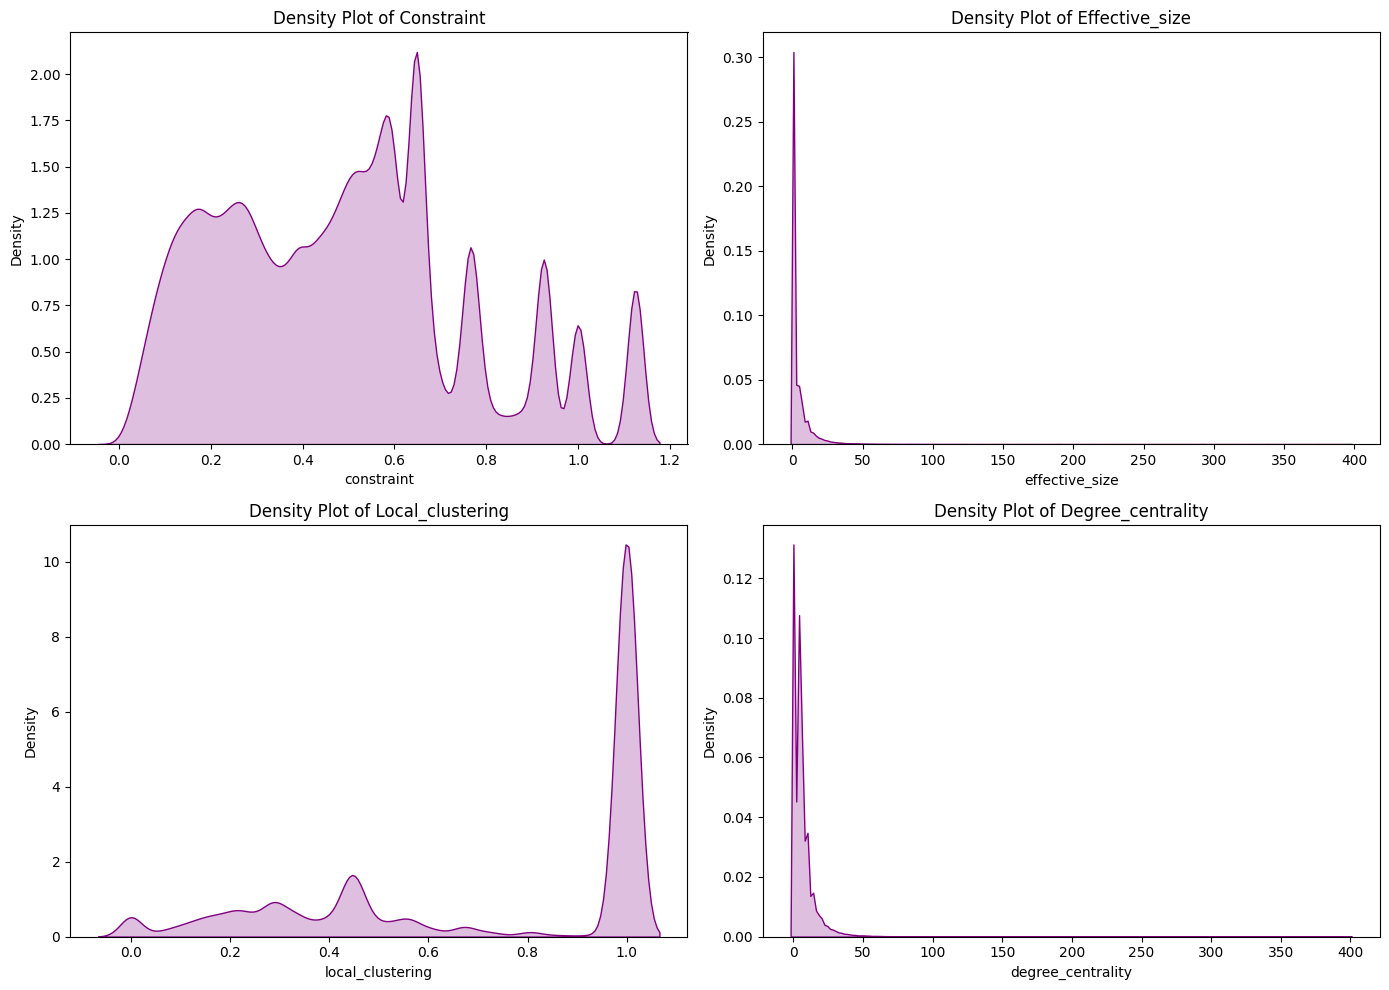

In [21]:
# Set up the matplotlib figure
plt.figure(figsize=(14, 10))

metrics = ['constraint', 'effective_size', 'local_clustering', 'degree_centrality']

# Loop through the metrics and create a subplot for each
for i, metric in enumerate(metrics, 1):
    plt.subplot(2, 2, i)
    sns.kdeplot(collaborator_brokerage[metric], fill=True, color='purple')
    plt.title(f'Density Plot of {metric.capitalize()}')
    plt.xlabel(metric)

# Adjust layout
plt.tight_layout()
plt.show()

**Constraint:**
- Both the mean and median values being 0.49 suggest a moderate level of constraint, meaning that collaborators typically experience a balanced level of dependency within their networks.
- Theoretically, constraint values should range from 0 to 1. Observing values slightly above 1 suggests instances of very high dependency on specific connections. We'll explore these cases later to understand their network dynamics.
- The relatively low standard deviation (0.27) indicates that most collaborators' constraint scores cluster around the mean, suggesting uniformity in network constraints among most individuals.

**Effective Size**
- The average effective size of about five suggests that collaborators can typically access new information from approximately five contacts.
-The median significantly lower than the mean points to a right-skewed distribution, influenced by a few collaborators with exceptionally expansive networks (probably those who worked on big budget movies with hundreds of creative proffessionals invovled).

**Local Clustering:**
High mean (0.73) and median values (1.00) highlight that many collaborators are part of highly interconnected groups. A median of 1 indicates that for half of the data, every possible tie within a collaborator's neighborhood is realized.

**Degree Centrality:**
- The average score suggests that collaborators are typically connected directly to nearly seven other individuals.
- The wide rangenge (0.00 to 399) means that a small number of collaborators have extremely high centrality, indicating they are highly influential or central within the network.

## Correlation analyses

Next, we explore how different network metrics—constraint, effective size, local clustering, and degree centrality—are related within our dataset. For this, we generate a correlation matrix:

In [28]:
collaborator_brokerage.drop(columns='collaborator_id').corr()

,constraint,effective_size,local_clustering,degree_centrality
constraint,1.00,-0.47,0.60,-0.53
effective_size,-0.47,1.00,-0.53,0.99
local_clustering,0.60,-0.53,1.00,-0.51
degree_centrality,-0.53,0.99,-0.51,1.00


- Constraint and Effective Size (-0.47): This moderate negative correlation means that as the constraint of a person increases (meaning their dependency on a few connections is higher), their effective size (number of useful, non-redundant contacts) tends to decrease. High constraint often indicates that a few connections are overly dominant, which naturally limits the number of useful, independent connections.
- Constraint and Local Clustering (0.60): This a positive correlation means that higher constraint levels often occur together with higher local clustering. This makes sense because when a collaborator’s network neighbors are highly interconnected (high local clustering), it can lead to a higher dependency on these neighbors (higher constraint).
- Constraint and Degree Centrality (-0.53): This negative correlation aligns with the notion that if a person is highly dependent on a few connections (high constraint), they are less likely to have a broad range of direct connections (low degree centrality).
- Effective Size and Local Clustering (-0.53): The negative correlation indicates that higher effective sizes (more unique and useful contacts) tend to correspond with lower levels of local clustering. This makes sense since a more extensive network with more unique connections generally leads to fewer tightly-knit clusters.
- Effective Size and Degree Centrality (0.99): This is a very high positive correlation, which is expected, as having a higher number of unique, non-redundant contacts (effective size) typically means a person also has a higher total number of direct connections (degree centrality).
- Local Clustering and Degree Centrality (-0.51): This moderate negative correlation implies that when a collaborator’s immediate network is tightly interconnected, they often do not have many connections in general (low degree of centrality).

These correlations reflect a natural trade-off between network diversity (effective size and degree centrality) and cohesion (local clustering and constraint). Networks that are very cohesive often lack diversity, and vice versa.

## Understanding extreme cases

Now, let's focus on specific groups of people with low brokerage potential: people with high constraint scores (both =1 and >1) and people with a local clustering of 1. 

**Constraint Scores Above 1**

Constraint scores typically range from 0 t1, where a score closer to 1 indicates a high level of dependency on interconnected network ties. Scores exceeding 1, though unusual, are possible due to specific way constraint is calculated (see [NetworkX's documentation](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.structuralholes.constraint.html)). This phenomenon often occurs in tightly-knit networks or cliques where a node has multiple redundant connections to other nodes that are also heavily interconnected.

To better understand the specific characteristics of nodes with constraint scores above 1, let's perform descriptive statistics analyses on the other network metrics (effective size, local clustering, degree centrality) of these people.

In [22]:
# Describe the distribution of scores for collaborators with a constraint score greater than 1, indicating over-constrained positions
collaborator_brokerage[collaborator_brokerage['constraint'] > 1].describe()

,constraint,effective_size,local_clustering,degree_centrality
count,34726.00,34726.00,34726.00,34726.00
mean,1.12,1.00,1.00,2.00
std,0.02,0.00,0.00,0.00
min,1.01,1.00,1.00,2.00
25%,1.12,1.00,1.00,2.00
50%,1.12,1.00,1.00,2.00
75%,1.12,1.00,1.00,2.00
max,1.12,1.00,1.00,2.00


For collaborators with a constraint score larger than 1, there is no variability in other metrics—effective size, local clustering, and degree centrality—meaning they have very similar network configuration:
- Effective Size (1.00) indicates that these collaborators are interacting within a very narrow circle, likely just one other node providing new information.
- Local Clustering (1.00) indicates a fully interconnected network where each contact is directly connected to every other.
- Degree Centrality (2.00) suggests that they each connect directly to only two others.

The combination of high constraint, an effective size of one, complete local clustering, and a minimal degree centrality paints a picture of a network that is highly insular.

**Constraint Scores of 1**

What about people with constraint scores of 1? What is the characteristics of their network? Again, let's generate descriptive statistics for these people to understand their network better.

In [23]:
# Describe the distribution of scores for collaborators with a constraint score exactly equal to 1, indicating a perfectly constrained position
collaborator_brokerage[collaborator_brokerage['constraint'] == 1].describe()

,constraint,effective_size,local_clustering,degree_centrality
count,24413.00,24413.00,24413.00,24413.00
mean,1.00,1.00,0.00,1.00
std,0.00,0.00,0.00,0.00
min,1.00,1.00,0.00,1.00
25%,1.00,1.00,0.00,1.00
50%,1.00,1.00,0.00,1.00
75%,1.00,1.00,0.00,1.00
max,1.00,1.00,0.00,1.00


For collaborators with a constraint score of 1, the lack of variability in other metrics—effective size, local clustering, and degree centrality—means that they all have the same network structure:
- Effective Size (1.00): These individuals gain information exclusively from one source, suggesting the absence of network diversity.
- Degree Centrality (1.00): A degree centrality of 1 indicates that these collaborators have a singular direct connection, underscoring their isolated position within the broader network.
- Local Clustering (0.00): A local clustering coefficient of 0 here is intriguing because it typically indicates that a node's neighbors are not connected to each other—contrary to what one might expect given the high constraint. However, because the degree centrality is also 1, it indicates these nodes likely have only one connection, making the concept of neighbor interconnectivity (local clustering) non-applicable.

These collaborators who has a constraint score of 1 are fully dependent on a singular connectork. Thus, they are similar to people with constraint scores greater than 1 in that both groups are in highly constrained environments with very limited capacity for brokerage. However, the difference is that while those with constraint scores greater than 1 often reside in densely interconnected groups or cliques, individuals with a constraint score of 1 are uniquely isolated with only one connection. This results in no local clustering compared to the complete interconnectivity (local clustering of 1) observed in the former group.

**Local Clustering Scores of 1**

Another group with limited capacity for brokerage is those with local clustering scores of 1, indicating that the immediate network neighbors of these people are all directly connected to each other, forming a completely interconnected group.

Let's generate descriptive statistics for these grouple to understand their network better.

In [25]:
# Describe scores for collaborators with a local clustering score of 1, indicating fully clustered network positions
collaborator_brokerage[collaborator_brokerage['local_clustering'] == 1].describe()

,constraint,effective_size,local_clustering,degree_centrality
count,527946.00,527946.00,527946.00,527946.00
mean,0.64,1.00,1.00,4.45
std,0.19,0.00,0.00,1.34
min,0.18,1.00,1.00,2.00
25%,0.51,1.00,1.00,4.00
50%,0.60,1.00,1.00,5.00
75%,0.77,1.00,1.00,5.00
max,1.12,1.00,1.00,9.00


Across all individuals in this subset, the effective size remains consistently at one. This indicates that despite having multiple contacts, only one provides new information, indicating a closed network that does not facilitate informational diversity.

An average constraint score of 0.64 among these individuals indicates a moderate dependency on their network ties. While deeply embedded within their groups, some times these individuals' ties are not excessively restrictive, allowing some degree of external interaction.

It might initially seem counterintuitive that someone can exhibit a local clustering of 1, an effective size of 1, yet not be overly dependent on their immediate contacts (demonstrated by a lower constraint score). However, this can occur due to broader network connections. That is, if the contacts within a person’s immediate, fully connected group also maintain diverse connections outside this group, it reduces the person's overall dependence on them. Each contact's external ties provide alternative pathways for the focal person to access diverse information and resources, reducing the focal person's constraint. 

**Local Clustering Scores of 0**

So far, we have focused on extreme cases of people embedded in closed networks with little brokerage potential. Now, we turn our attention to the other extreme-those whose immediate neighbors do not connect with each other at all, suggesting a network structure where each connection potentially offers unique, non-redundant information.

Let's see the network profiles of everyone with a local clustering of 0.

In [27]:
# Identify and display unique cases of collaborators with a local clustering score of 0, indicating no clustering in their local network
collaborator_brokerage[collaborator_brokerage['local_clustering'] == 0].drop(columns='collaborator_id').drop_duplicates()

,constraint,effective_size,local_clustering,degree_centrality
1525,1.00,1.00,0.00,1
10105,0.50,2.00,0.00,2
48837,0.33,3.00,0.00,3
230194,0.25,4.00,0.00,4
902372,0.20,5.00,0.00,5
902373,0.17,6.00,0.00,6


A highest constraint score (1) and lowest effective size and degree centrality (1) in this context likely indicates a collaborator with only one connection or very few, highly dependent connections. However, in other cases when local clustering is 0, we see that degree centrality and effective size is equal to each other, indicating all contacts are unconnected and thus are non-redundant contacts.

# Calculating brokerage potential through reverse metrics

We now focus on deriving people's brokerage potential from the calculated scores.
- Effective Size directly signifies brokerage potential by measuring the number of non-redundant connections a node possesses. This metric illustrates the extent to which an individual can access unique resources and information through their direct ties.
- Constraint gauges a node's dependency on its neighbors. A higher constraint score indicates a stronger reliance on a limited number of connections, which may restrict the node's ability to function as an effective broker.
- Local Clustering evaluates the degree to which a node's neighbors are interconnected. A high local clustering score suggests that the node is embedded within a closely-knit group, potentially limiting its capacity to bridge diverse parts of the network.

**Reverse Metrics**

What this means is that someone's potential to act as a broker is inversely related to their constraint and local clustering scores. Thus, to assess someone's brokerage potential, we employ reverse metrics:
- Reverse Constraint: We calculate this as 1 + $\epsilon$ - constraint, where $\epsilon$ is a very small number. This approach ensures that even nodes with extremely high constraint scores receive a minimal but non-zero brokerage score. Only those with 0 connection will receive a brokerage score of 0. Overall, this metric inversely reflects constraint, emphasizing nodes with lower scores as having higher potential for brokerage.
- Reverse Local Clustering: Similarly, this is calculated as 1 + $\epsilon$ - local clustering. This score highlights nodes with the potential to connect otherwise disparate groups, inversely proportional to their clustering score.

**Implementing Reverse Score Calculations**

- We define functions to calculate reverse metrics for both constraint and local clustering. These functions account for various scenarios, including missing scores or extreme values.
- The `apply_reverse_scores` function is applied to each row in the `collaborators_by_year` DataFrame. It recalculates each collaborator’s original scores, computes the reverse metrics, and updates the dataset accordingly.
- The `compute_stats` function then extracts and computes both average and maximum values for each type of score for each director-year pair. This analysis provides a detailed overview of the distribution and extent of brokerage potential of each director's collaborators at the time of their collaboration.

In [29]:
epsilon = 1e-5  # Define a very small number

# define functions for calculating reverse scores 
def calculate_reverse_constraint(constraint, degree_centrality):
    if constraint is None:
        return 0
    elif degree_centrality == 1:
        return epsilon
    elif constraint > 1:
        return epsilon
    else:
        return 1 + epsilon - constraint

def calculate_reverse_local_clustering(local_clustering, degree_centrality):
    if local_clustering is None:
        return 0
    elif degree_centrality == 1:
        return epsilon
    else:
        return 1 + epsilon - local_clustering

# define function to recalculate constraint and local clustering and calculate their reverse scores
def apply_reverse_scores(row):
    updated_scores = []
    for score_dict in row['brokerage_scores']:
        for nconst, scores in score_dict.items():
            # Fetch original scores
            original_constraint = scores.get('constraint')
            original_local_clustering = scores.get('local_clustering')
            degree_centrality = scores.get('degree_centrality')

            # Initialize recalculated scores with original values or 0 if None
            recalculated_constraint = original_constraint if original_constraint is not None else 0
            recalculated_local_clustering = original_local_clustering if original_local_clustering is not None else 0

            # Apply conditions for recalculations
            if degree_centrality == 1:
                recalculated_constraint = epsilon
                recalculated_local_clustering = epsilon

            # Calculate reverse scores using the original values
            reverse_constraint = calculate_reverse_constraint(original_constraint, degree_centrality)
            reverse_local_clustering = calculate_reverse_local_clustering(original_local_clustering, degree_centrality)

            # Update the dictionary with original, recalculated, and reverse scores
            scores['recalculated_constraint'] = recalculated_constraint
            scores['recalculated_local_clustering'] = recalculated_local_clustering
            scores['reverse_constraint'] = reverse_constraint
            scores['reverse_local_clustering'] = reverse_local_clustering

            updated_scores.append({nconst: scores})
    return updated_scores

# Apply the function to update brokerage_scores with original, recalculated, and reverse scores
collaborators_by_year['brokerage_scores'] = collaborators_by_year.apply(apply_reverse_scores, axis=1)

In [30]:
collaborators_by_year.head()

,nconst_director,year,nconst,brokerage_scores
0,nm0000083,2007,"[nm1677271, nm0653114, nm0690875, nm0917916, nm0613273]","[{'nm1677271': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0, 'recalculated_constraint': 0, 'recalculated_local_clustering': 0, 'reverse_constraint': 0, 'reverse_local_clustering': 0}}, {'nm0653114': {'constraint': 0.1548834263960852, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14, 'recalculated_constraint': 0.1548834263960852, 'recalculated_local_clustering': 0.2857142857142857, 'reverse_constraint': 0.8451265736039149, 'reverse_local_clustering': 0.7142957142857144}}, {'nm0690875': {'constraint': 0.6480000000000001, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.6480000000000001, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.35200999999999993, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0917916': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0, 'recalculated_constraint': 0, 'recalculated_local_clustering': 0, 'reverse_constraint': 0, 'reverse_local_clustering': 0}}, {'nm0613273': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0, 'recalculated_constraint': 0, 'recalculated_local_clustering': 0, 'reverse_constraint': 0, 'reverse_local_clustering': 0}}]"
1,nm0000083,2008,"[nm1677271, nm0653114, nm0690875, nm0917916, nm0613273]","[{'nm1677271': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1259692370646298, 'effective_size': 15.210526315789474, 'local_clustering': 0.21052631578947367, 'degree_centrality': 19, 'recalculated_constraint': 0.1259692370646298, 'recalculated_local_clustering': 0.21052631578947367, 'reverse_constraint': 0.8740407629353703, 'reverse_local_clustering': 0.7894836842105264}}, {'nm0690875': {'constraint': 0.30364764542936296, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'recalculated_constraint': 0.30364764542936296, 'recalculated_local_clustering': 0.4444444444444444, 'reverse_constraint': 0.6963623545706371, 'reverse_local_clustering': 0.5555655555555556}}, {'nm0917916': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0613273': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}]"
2,nm0000083,2009,"[nm1677271, nm0653114, nm0690875, nm0917916, nm0613273]","[{'nm1677271': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1654934959096975, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14, 'recalculated_constraint': 0.1654934959096975, 'recalculated_local_clustering': 0.2857142857142857, 'reverse_constraint': 0.8345165040903025, 'reverse_local_clustering': 0.7142957142857144}}, {'nm0690875': {'constraint': 0.30614693877551025, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'reca

In [31]:
def compute_stats(row):
    # Extract the list of brokerage scores dictionaries for the row
    brokerage_scores = row['brokerage_scores']
    
    # Initialize lists to hold each type of score for aggregation
    constraint_scores = []
    local_clustering_scores = []
    reverse_constraint_scores = []
    effective_size_scores = []
    reverse_local_clustering_scores = []
    degree_centrality_scores = []
    
    # Iterate through each brokerage scores dictionary, extracting the scores
    for score_dict in brokerage_scores:
        for scores in score_dict.values():
            if 'recalculated_constraint' in scores and scores['recalculated_constraint'] is not None:
                constraint_scores.append(scores['recalculated_constraint'])
            if 'recalculated_local_clustering' in scores and scores['recalculated_local_clustering'] is not None:
                local_clustering_scores.append(scores['recalculated_local_clustering'])
            if 'reverse_constraint' in scores and scores['reverse_constraint'] is not None:
                reverse_constraint_scores.append(scores['reverse_constraint'])
            if 'effective_size' in scores and scores['effective_size'] is not None:
                effective_size_scores.append(scores['effective_size'])
            if 'reverse_local_clustering' in scores and scores['reverse_local_clustering'] is not None:
                reverse_local_clustering_scores.append(scores['reverse_local_clustering'])
            if 'degree_centrality' in scores and scores['degree_centrality'] is not None:
                degree_centrality_scores.append(scores['degree_centrality'])    
    
    # Compute the number of collaborators, average, and maximum for each type of score
    num_collaborators = len(brokerage_scores)
    avg_constraint = np.mean(constraint_scores) if constraint_scores else 0
    max_constraint = np.max(constraint_scores) if constraint_scores else 0
    avg_local_clustering = np.mean(local_clustering_scores) if local_clustering_scores else 0
    max_local_clustering = np.max(local_clustering_scores) if local_clustering_scores else 0
    avg_reverse_constraint = np.mean(reverse_constraint_scores) if reverse_constraint_scores else 0
    max_reverse_constraint = np.max(reverse_constraint_scores) if reverse_constraint_scores else 0
    avg_effective_size = np.mean(effective_size_scores) if effective_size_scores else 0
    max_effective_size = np.max(effective_size_scores) if effective_size_scores else 0
    avg_reverse_local_clustering = np.mean(reverse_local_clustering_scores) if reverse_local_clustering_scores else 0
    max_reverse_local_clustering = np.max(reverse_local_clustering_scores) if reverse_local_clustering_scores else 0
    avg_degree_centrality = np.mean(degree_centrality_scores) if degree_centrality_scores else 0
    max_degree_centrality = np.max(degree_centrality_scores) if degree_centrality_scores else 0
    
    # Return a dictionary with the computed statistics for each type of brokerage score
    return {
        'num_collaborators': num_collaborators,
        'avg_constraint': avg_constraint,
        'max_constraint': max_constraint,
        'avg_local_clustering': avg_local_clustering,
        'max_local_clustering': max_local_clustering,
        'avg_reverse_constraint': avg_reverse_constraint,
        'max_reverse_constraint': max_reverse_constraint,
        'avg_effective_size': avg_effective_size,
        'max_effective_size': max_effective_size,
        'avg_reverse_local_clustering': avg_reverse_local_clustering,
        'max_reverse_local_clustering': max_reverse_local_clustering,
        'avg_degree_centrality': avg_degree_centrality,
        'max_degree_centrality': max_degree_centrality
    }

# Apply the function to each row in the DataFrame to create new columns for the computed statistics
stats = collaborators_by_year.apply(compute_stats, axis=1, result_type='expand')

# Concatenate the original DataFrame with the new statistics DataFrame to include the computed stats
collaborators_by_year = pd.concat([collaborators_by_year, stats], axis=1)

In [32]:
# Display the first few rows of the updated DataFrame with the new variables to verify successful computation
collaborators_by_year.head()

,nconst_director,year,nconst,brokerage_scores,num_collaborators,avg_constraint,max_constraint,avg_local_clustering,max_local_clustering,avg_reverse_constraint,max_reverse_constraint,avg_effective_size,max_effective_size,avg_reverse_local_clustering,max_reverse_local_clustering,avg_degree_centrality,max_degree_centrality
0,nm0000083,2007,"[nm1677271, nm0653114, nm0690875, nm0917916, nm0613273]","[{'nm1677271': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0, 'recalculated_constraint': 0, 'recalculated_local_clustering': 0, 'reverse_constraint': 0, 'reverse_local_clustering': 0}}, {'nm0653114': {'constraint': 0.1548834263960852, 'effective_size': 10.285714285714285, 'local_clustering': 0.2857142857142857, 'degree_centrality': 14, 'recalculated_constraint': 0.1548834263960852, 'recalculated_local_clustering': 0.2857142857142857, 'reverse_constraint': 0.8451265736039149, 'reverse_local_clustering': 0.7142957142857144}}, {'nm0690875': {'constraint': 0.6480000000000001, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.6480000000000001, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.35200999999999993, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0917916': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0, 'recalculated_constraint': 0, 'recalculated_local_clustering': 0, 'reverse_constraint': 0, 'reverse_local_clustering': 0}}, {'nm0613273': {'constraint': None, 'effective_size': None, 'local_clustering': None, 'degree_centrality': 0, 'recalculated_constraint': 0, 'recalculated_local_clustering': 0, 'reverse_constraint': 0, 'reverse_local_clustering': 0}}]",5.00,0.16,0.65,0.26,1.00,0.24,0.85,5.64,10.29,0.14,0.71,3.80,14.00
1,nm0000083,2008,"[nm1677271, nm0653114, nm0690875, nm0917916, nm0613273]","[{'nm1677271': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1259692370646298, 'effective_size': 15.210526315789474, 'local_clustering': 0.21052631578947367, 'degree_centrality': 19, 'recalculated_constraint': 0.1259692370646298, 'recalculated_local_clustering': 0.21052631578947367, 'reverse_constraint': 0.8740407629353703, 'reverse_local_clustering': 0.7894836842105264}}, {'nm0690875': {'constraint': 0.30364764542936296, 'effective_size': 6.0, 'local_clustering': 0.4444444444444444, 'degree_centrality': 10, 'recalculated_constraint': 0.30364764542936296, 'recalculated_local_clustering': 0.4444444444444444, 'reverse_constraint': 0.6963623545706371, 'reverse_local_clustering': 0.5555655555555556}}, {'nm0917916': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0613273': {'constraint': 0.5141274238227147, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5141274238227147, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.48588257617728536, 'reverse_local_clustering': 1.0000000000065512e-05}}]",5.00,0.39,0.51,0.73,1.00,0.61,0.87,4.84,15.21,0.27,0.79,8.80,19.00
2,nm0000083,2009,"[nm1677271, nm0653114, nm0690875, nm0917916, nm0613273]","[{'nm1677271': {'constraint': 0.5236734693877552, 'effective_size': 1.0, 'local_clustering': 1.0, 'degree_centrality': 5, 'recalculated_constraint': 0.5236734693877552, 'recalculated_local_clustering': 1.0, 'reverse_constraint': 0.4763365306122449, 'reverse_local_clustering': 1.0000000000065512e-05}}, {'nm0653114': {'constraint': 0.1654934959096975, 'effective_size': 10.2857142

# Incorporating collaborators' network metrics into directors' career data

In the earlier phase of our study, `Phase_4_Building_Time_Series_Data.ipynb`, we created `directors_years`, which traced each director's career journey year by year from their debut up to 2023. By merging this data with `collaborators_by_year`, we can add to it the brokerage scores of their collaborators at the time of the collaboration. 

The updated `directors_years` dataset will have the following columns:
- Director Identifier (`nconst_director`): A unique identifier for each director.
- Career Year (`year`): The specific year being considered within the director’s career.
- Collaborators' Network Metrics: (`collaborator_avg_reverse_constraint`, `collaborator_avg_effective_size`, etc.): The average and maximum values for reverse constraint, effective size, reverse local clustering, and degree centrality of collaborators, providing a quantifiable measure of the collaborators' network breadth and depth for that year.

Along with other variables calculated previously:
- `debut_year`: The year when the director made their debut.
- `num_movies`: The number of movies released by the director in that particular year.
- `made_movie`: A binary indicator stating whether the director released any movies in that year (1 if yes, 0 if no).
- `dropout`: Indicates whether the director is considered to have potentially dropped out of the industry by that year.
- `start_time` and `stop_time`: Relative metrics indicating the duration since debut and potential end of career.

**Addressing Data Gaps**

Not all directors have complete data regarding their collaborators:
- Directors without collaborators: For directors who do not have any collaborators listed on their movies, we retain NA values in the brokerage scores to reflect the absence of network data.
- Directors with inactive career periods: For directors with periods of inactivity (no films releases in the preceding three years), we assign a score of 0 for collaborators' network metrics, indicating no network activity during those inactive periods.

In [4]:
# Load the 'directors_years' DataFrame, which includes annual data for each director
directors_years = pd.read_csv("directors_years.csv")

In [33]:
# Display the first few rows to inspect the structure of the data
directors_years.head()

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time
0,nm1131265,2004,2004,0.00,0,NaN,0,0,1
1,nm1131265,2005,2004,0.00,0,NaN,0,1,2
2,nm1131265,2006,2004,0.00,0,NaN,0,2,3
3,nm1131265,2007,2004,0.00,0,NaN,0,3,4
4,nm1131265,2008,2004,0.00,0,NaN,0,4,5


In the `directors_years` dataset, each row represents a single year in the career of a director, with `nconst_director` as a unique identifier for each director and `year` as the specific year being considered for that director's career, along with other columns reflecting their debut year, number of movies made in the focal year, etc. 

Now we merge it with `collaborators_by_year` to add collaborators' brokerage scores at each year of their career. 

In [34]:
# Merge the directors' annual data with the collaborators' network statistics from the 'collaborators_by_year' dataset.
# We exclude certain columns from the 'collaborators_by_year' that are not needed for further analysis.
directors_years = pd.merge(directors_years, 
                           collaborators_by_year.drop(columns=['nconst', 'brokerage_scores', 
                                                               'avg_constraint', 'max_constraint', 
                                                               'avg_local_clustering', 'max_local_clustering']),
                           how='left')

# Display the first 40 rows to verify the merge was successful and to understand the updated structure.
directors_years.head(40)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time,num_collaborators,avg_reverse_constraint,max_reverse_constraint,avg_effective_size,max_effective_size,avg_reverse_local_clustering,max_reverse_local_clustering,avg_degree_centrality,max_degree_centrality
0,nm1131265,2004,2004,0.00,0,NaN,0,0,1,5.00,0.04,0.22,1.00,1.00,0.00,0.00,0.60,3.00
1,nm1131265,2005,2004,0.00,0,NaN,0,1,2,5.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm1131265,2006,2004,0.00,0,NaN,0,2,3,5.00,0.51,0.84,3.64,14.22,0.16,0.78,7.60,18.00
3,nm1131265,2007,2004,0.00,0,NaN,0,3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,nm1131265,2008,2004,0.00,0,NaN,0,4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,nm1131265,2009,2004,0.00,0,NaN,0,5,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,nm1131265,2010,2004,0.00,0,NaN,0,6,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,nm1131265,2011,2004,0.00,0,NaN,0,7,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,nm1131265,2012,2004,0.00,0,NaN,0,8,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,nm1131265,2013,2004,1.00,1,NaN,0,9,10,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Next, we identify directors without any records of collaborators. These are directors resent in `directors_full_filmography` but absent in `directors_network`.

In [37]:
# Display the first few rows of the directors' full filmography
directors_full_filmography.head()

,tconst,startYear,genres,nconst,firstYear,averageRating,numVotes
0,tt0108549,2004.00,"Comedy,Mystery",nm1131265,2004.00,7.80,34.00
1,tt0108549,2004.00,"Comedy,Mystery",nm1130611,2004.00,7.80,34.00
2,tt0117461,2003.00,"Comedy,Romance",nm0290651,2003.00,6.30,24.00
3,tt0117743,2008.00,"Drama,Romance",nm0404033,2003.00,6.70,64.00
4,tt0118141,2005.00,Drama,nm0000417,2005.00,5.30,950.00


In [38]:
# Extract sets of unique director IDs from both the full filmography and the network data to identify discrepancies.
directors_in_full_filmography = set(directors_full_filmography['nconst'].unique())
directors_in_network = set(directors_network['nconst_director'].unique())

# Identify directors who are present in the full filmography dataset but not in the network dataset.
# These directors do not have any network connections recorded, possibly due to missing data or other issues.
directors_no_networks = directors_in_full_filmography - directors_in_network

In [39]:
# Display the number of directors who have no network data.
len(directors_no_networks)

4895

So among the 63,169 directors in our sample, 4895 don't have any collaborators listed on the films. We'll leave their collaborators' brokerage metrics as NA, to reflect the unavailability of network data.

For directors with some network data, we fill missing values with 0 in collaborators' network metrics to indicate years with no network activity. 

In [40]:
# Define the columns that we need to fill in NA values. These columns represent collaborators' network statistics.
columns_to_check = [
    'num_collaborators', 
    'avg_reverse_constraint', 
    'max_reverse_constraint', 
    'avg_effective_size', 
    'max_effective_size', 
    'avg_reverse_local_clustering', 
    'max_reverse_local_clustering',
    'avg_degree_centrality',
    'max_degree_centrality'
]

In [42]:
# Create a Boolean Series to identify directors who have network data.
# This Series is true for directors with network information and false for those without.
has_network_info = ~directors_years['nconst_director'].isin(directors_no_networks)

# For directors with available network data, replace NA values with 0 in the specified network statistic columns.
# This step ensures that absence of data due to inactivity or lack of connections is represented as 0 rather than NA.
directors_years.loc[has_network_info, columns_to_check] = directors_years.loc[has_network_info, columns_to_check].fillna(0)

In [44]:
# Display the first 20 rows to check that the fill operation was successful and data is as expected.
directors_years.head(20)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time,num_collaborators,avg_reverse_constraint,max_reverse_constraint,avg_effective_size,max_effective_size,avg_reverse_local_clustering,max_reverse_local_clustering,avg_degree_centrality,max_degree_centrality
0,nm1131265,2004,2004,0.00,0,NaN,0,0,1,5.00,0.04,0.22,1.00,1.00,0.00,0.00,0.60,3.00
1,nm1131265,2005,2004,0.00,0,NaN,0,1,2,5.00,0.51,0.83,3.67,14.33,0.16,0.78,7.60,18.00
2,nm1131265,2006,2004,0.00,0,NaN,0,2,3,5.00,0.51,0.84,3.64,14.22,0.16,0.78,7.60,18.00
3,nm1131265,2007,2004,0.00,0,NaN,0,3,4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,nm1131265,2008,2004,0.00,0,NaN,0,4,5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,nm1131265,2009,2004,0.00,0,NaN,0,5,6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,nm1131265,2010,2004,0.00,0,NaN,0,6,7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,nm1131265,2011,2004,0.00,0,NaN,0,7,8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,nm1131265,2012,2004,0.00,0,NaN,0,8,9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,nm1131265,2013,2004,1.00,1,NaN,0,9,10,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Looks great!

One more thing to do, let's rename the network columns to better reflect that these are collaborators' network scores, not the directors'.

In [6]:
# List of specific columns to rename
columns_to_rename = [
    'avg_reverse_constraint',
    'max_reverse_constraint',
    'avg_effective_size',
    'max_effective_size',
    'avg_reverse_local_clustering',
    'max_reverse_local_clustering',
    'avg_degree_centrality',
    'max_degree_centrality'
]

# Creating a dictionary to rename the specific columns
rename_dict = {col: f"collaborator_{col}" for col in columns_to_rename}

# Renaming the specific columns
directors_years.rename(columns=rename_dict, inplace=True)

# Print the updated DataFrame to check the new column names
directors_years.head()


,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time,num_collaborators,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,collaborator_avg_effective_size,collaborator_max_effective_size,collaborator_avg_reverse_local_clustering,collaborator_max_reverse_local_clustering,collaborator_avg_degree_centrality,collaborator_max_degree_centrality
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1,5.0,0.043752,0.218760,1.000000,1.000000,0.000002,0.000010,0.6,3.0
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2,5.0,0.512064,0.832831,3.666667,14.333333,0.156873,0.784324,7.6,18.0
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3,5.0,0.513025,0.837636,3.644444,14.222222,0.155566,0.777788,7.6,18.0
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0


# Incorporating collaborators' brokerage scores at directors' debut

In addition to testing the influence of the brokerage social capital of the collaborators directors have throughout their career, we will also look at the social capital of their collaborators when they first entered the industry. This helps us understand how these early connections can set the stage for future opportunities and career development.

Thus, let's extract the brokerage scores for collaborators during each director's debut year and merge them back into two datasets created in `Phase_4_Building_Time_Series_Data.ipynb`:
- Time Series Data (`directors_years`): This dataset tracks the annual progress of directors from their debut year through to 2023. Integrating debut year collaborator brokerage scores here allows us to assess the influence of early networks at different point in a director's career.
- Cross-Sectional Data (`directors_cross_sectional`): This dataset provides a cumulative view of each director's career. Integrating debut year brokerage scores here allows us to assess the overarching influence of early networks across the director's entire career.

In [7]:
# Filter the 'directors_years' DataFrame to only include rows where the 'year' matches the director's debut year.
# This subset will focus on capturing the conditions at the start of each director's career.
debut_stats = directors_years[directors_years['year'] == directors_years['debut_year']]

# Display a preview of 'debut_stats' to confirm the correct rows have been selected.
debut_stats.head()

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time,num_collaborators,collaborator_avg_reverse_constraint,collaborator_max_reverse_constraint,collaborator_avg_effective_size,collaborator_max_effective_size,collaborator_avg_reverse_local_clustering,collaborator_max_reverse_local_clustering,collaborator_avg_degree_centrality,collaborator_max_degree_centrality
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1,5.0,0.043752,0.218760,1.000000,1.000000,0.000002,0.00001,0.6,3.0
20,nm1130611,2004,2004,0.0,0,2005.0,0,0,1,5.0,0.043752,0.218760,1.000000,1.000000,0.000002,0.00001,0.6,3.0
40,nm0290651,2003,2003,0.0,0,2004.0,0,0,1,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
61,nm0404033,2003,2003,0.0,0,NaN,0,0,1,5.0,0.176096,0.880482,17.454545,17.454545,0.156712,0.78356,4.4,22.0
82,nm0000417,2005,2005,0.0,0,2008.0,0,0,1,4.0,0.146040,0.584159,3.000000,3.000000,0.100002,0.40001,1.5,6.0


In [8]:
# Select and concatenate the director ID and the last nine columns from 'debut_stats' which contain the relevant 
# network statistics for further analysis.
debut_stats = pd.concat([debut_stats.iloc[:, :1], debut_stats.iloc[:, -9:]], axis=1)

# Rename columns to specifically indicate these statistics are from the directors' debut years.
# This helps in distinguishing these values from their entire career statistics in the dataset.
debut_stats.rename(columns={
    'num_collaborators': 'debut_num_collaborators',
    'collaborator_avg_reverse_constraint': 'debut_collaborator_avg_reverse_constraint',
    'collaborator_max_reverse_constraint': 'debut_collaborator_max_reverse_constraint',
    'collaborator_avg_effective_size': 'debut_collaborator_avg_effective_size',
    'collaborator_max_effective_size': 'debut_collaborator_max_effective_size',
    'collaborator_avg_reverse_local_clustering': 'debut_collaborator_avg_reverse_local_clustering',
    'collaborator_max_reverse_local_clustering': 'debut_collaborator_max_reverse_local_clustering',
    'collaborator_avg_degree_centrality': 'debut_collaborator_avg_degree_centrality',
    'collaborator_max_degree_centrality': 'debut_collaborator_max_degree_centrality'
}, inplace=True)

# Display the first few rows of updated 'debut_stats' to ensure the column renaming was successful.
debut_stats.head()

,nconst_director,debut_num_collaborators,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
0,nm1131265,5.0,0.043752,0.218760,1.000000,1.000000,0.000002,0.00001,0.6,3.0
20,nm1130611,5.0,0.043752,0.218760,1.000000,1.000000,0.000002,0.00001,0.6,3.0
40,nm0290651,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
61,nm0404033,5.0,0.176096,0.880482,17.454545,17.454545,0.156712,0.78356,4.4,22.0
82,nm0000417,4.0,0.146040,0.584159,3.000000,3.000000,0.100002,0.40001,1.5,6.0


In [9]:
# Merge the modified 'debut_stats' back into the 'directors_years' DataFrame on the director ID ('nconst_director'),
# enhancing the dataset with collaborators' network statistics from each director's debut year.
directors_years = pd.merge(directors_years, debut_stats, on='nconst_director', how='left')

# Display the first 20 rows of 'directors_years' after merging to confirm the addition of debut year statistics.
directors_years.head(20)

,nconst_director,year,debut_year,num_movies,made_movie,dropoutYear,dropout,start_time,stop_time,num_collaborators,...,collaborator_max_degree_centrality,debut_num_collaborators,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
0,nm1131265,2004,2004,0.0,0,NaN,0,0,1,5.0,...,3.0,5.0,0.043752,0.21876,1.0,1.0,0.000002,0.00001,0.6,3.0
1,nm1131265,2005,2004,0.0,0,NaN,0,1,2,5.0,...,18.0,5.0,0.043752,0.21876,1.0,1.0,0.000002,0.00001,0.6,3.0
2,nm1131265,2006,2004,0.0,0,NaN,0,2,3,5.0,...,18.0,5.0,0.043752,0.21876,1.0,1.0,0.000002,0.00001,0.6,3.0
3,nm1131265,2007,2004,0.0,0,NaN,0,3,4,0.0,...,0.0,5.0,0.043752,0.21876,1.0,1.0,0.000002,0.00001,0.6,3.0
4,nm1131265,2008,2004,0.0,0,NaN,0,4,5,0.0,...,0.0,5.0,0.043752,0.21876,1.0,1.0,0.000002,0.00001,0.6,3.0
5,nm1131265,2009,2004,0.0,0,NaN,0,5,6,0.0,...,0.0,5.0,0.043752,0.21876,1.0,1.0,0.000002,0.00001,0.6,3.0
6,nm1131265,2010,2004,0.0,0,NaN,0,6,7,0.0,...,0.0,5.0,0.043752,0.21876,1.0,1.0,0.000002,0.00001,0.6,3.0
7,nm1131265,2011,2004,0.0,0,NaN,0,7,8,0.0,...,0.0,5.0,0.043752,0.21876,1.0,1.0,0.000002,0.00001,0.6,3.0
8,nm1131265,2012,2004,0.0,0,NaN,0,8,9,0.0,...,0.0,5.0,0.043752,0.21876,1.0,1.0,0.000002,0.00001,0.6,3.0
9,nm1131265,2013,2004,1.0,1,NaN,0,9,10,1.0,...,0.0,5.0,0.043752,0.21876,1.0,1.0,0.000002,0.00001,0.6,3.0


In [14]:
directors_years.to_csv("directors_years.csv")

In [10]:
# Load a separate cross-sectional dataset that summarizes directors' entire careers.
directors_cross_sectional = pd.read_csv("directors_cross_sectional.csv")

In [11]:
directors_cross_sectional.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies
0,nm1131265,2004,9.0,1,1.0
1,nm1130611,2004,11.0,0,0.0
2,nm0290651,2003,11.0,0,0.0
3,nm0404033,2003,5.0,1,1.0
4,nm0000417,2005,2.0,1,1.0


In [12]:
# Merge the debut year statistics into the cross-sectional dataset, aligning data by director ID.
# This operation integrates collaborators' network statistics into the broader career summaries.
directors_cross_sectional = pd.merge(directors_cross_sectional, debut_stats, on='nconst_director', how='left')

# Display the first few rows of the updated cross-sectional dataset to verify the successful merge of debut year data.
directors_cross_sectional.head()

,nconst_director,debut_year,time_to_second_movie,event,total_movies,debut_num_collaborators,debut_collaborator_avg_reverse_constraint,debut_collaborator_max_reverse_constraint,debut_collaborator_avg_effective_size,debut_collaborator_max_effective_size,debut_collaborator_avg_reverse_local_clustering,debut_collaborator_max_reverse_local_clustering,debut_collaborator_avg_degree_centrality,debut_collaborator_max_degree_centrality
0,nm1131265,2004,9.0,1,1.0,5.0,0.043752,0.218760,1.000000,1.000000,0.000002,0.00001,0.6,3.0
1,nm1130611,2004,11.0,0,0.0,5.0,0.043752,0.218760,1.000000,1.000000,0.000002,0.00001,0.6,3.0
2,nm0290651,2003,11.0,0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.0,0.0
3,nm0404033,2003,5.0,1,1.0,5.0,0.176096,0.880482,17.454545,17.454545,0.156712,0.78356,4.4,22.0
4,nm0000417,2005,2.0,1,1.0,4.0,0.146040,0.584159,3.000000,3.000000,0.100002,0.40001,1.5,6.0


In [13]:
directors_cross_sectional.to_csv("directors_cross_sectional.csv")

# Getting directors' brokerage scores

Finally, we write another function to append brokerage metrics for the directors themselves. This new function, `append_director_scores`, is designed to fetch the director's brokerage scores (constraint, effective size, local clustering) from the dictionary `brokerage_scores_by_year` based on their ID (`nconst_director`) and the specific year (`year`). We then apply the function to each row of the `directors_years` DataFrame to integrate the director's scores for each year of their career. This approach ensures that our dataset not only reflects the social capital of collaborators but also of the directors themselves at the time of their collaboration.

In [7]:
directors_brokerage = directors_years[['nconst_director', 'year', 'num_collaborators']]
directors_brokerage

In [ ]:
epsilon = 1e-5  # Define a very small number to prevent zero values in brokerage calculations

def reverse_constraint(constraint, num_collaborators):
    if constraint is None:
        return 0  # No brokerage potential when data is not available
    elif constraint > 1 or num_collaborators == 1:
        return epsilon  # Minimal brokerage potential for high constraints or single collaborator
    else:
        return 1 + epsilon - constraint  # Higher reverse scores for lower constraints

def reverse_local_clustering(local_clustering, num_collaborators):
    if local_clustering is None:
        return 0  # No brokerage potential when data is not available
    elif num_collaborators == 1:
        return epsilon  # Minimal brokerage potential for nodes with only one neighbor
    else:
        return 1 + epsilon - local_clustering  # Higher reverse scores for lower clustering


In [ ]:
def append_director_scores(row):
    director_id = row['nconst_director']
    year = row['year']
    num_collaborators = row['num_collaborators']
    
    # Fetch the brokerage scores for the director from the pre-loaded dictionary
    director_constraint = brokerage_scores_by_year.get(year, {}).get('constraint', {}).get(director_id, None)
    director_effective_size = brokerage_scores_by_year.get(year, {}).get('effective_size', {}).get(director_id, None)
    director_local_clustering = brokerage_scores_by_year.get(year, {}).get('local_clustering', {}).get(director_id, None)

    # Append the director's scores to the row
    row['director_constraint'] = director_constraint
    row['director_effective_size'] = director_effective_size
    row['director_local_clustering'] = director_local_clustering

    # Calculate and append reverse scores considering the number of collaborators
    row['director_reverse_constraint'] = reverse_constraint(director_constraint, num_collaborators)
    row['director_reverse_local_clustering'] = reverse_local_clustering(director_local_clustering, num_collaborators)

    return row

# Apply the function to each row in the DataFrame to add the director's scores along with their reverse scores
directors_brokerage = directors_brokerage.apply(append_director_scores, axis=1)

In [16]:
# save the data for future analysis 
directors_brokerage.to_csv('directors_brokerage.csv', index=False)